In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from tqdm.notebook import tqdm 
import scipy
import os
import glob
import re
import open3d as o3d 
%config InlineBackend.figure_format = 'retina'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def natural_sort(l):
    '''https://stackoverflow.com/a/4836734
    
    Sorts the given list in the way that humans expect.
    '''
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]
    
def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

In [4]:
c = np.load('data/casper/calib.npy', allow_pickle=True).item()
K0, d0, K1, d1, R, t = c['K0'], c['d0'], c['K1'], c['d1'], c['R'], c['t']

## 13.1
If the cameras were not calibrated, you would need to calibrate them first.
- Use checkerboards to compute the essential and/or fundamental matrix. 

How would you find their intrinsics?

- Camera matrix
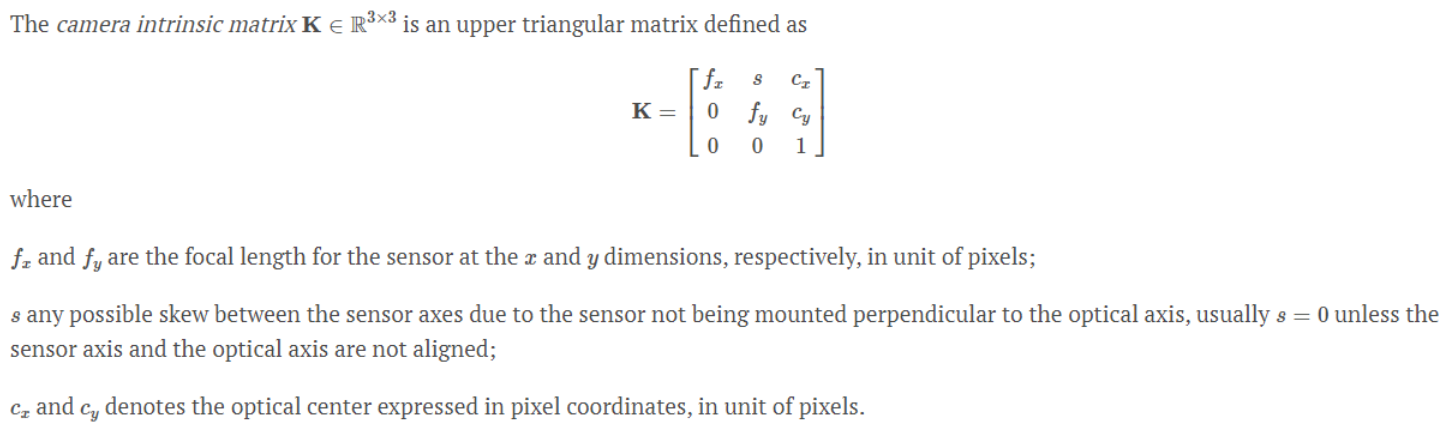

What about the extrinsics?

- Pose matrix

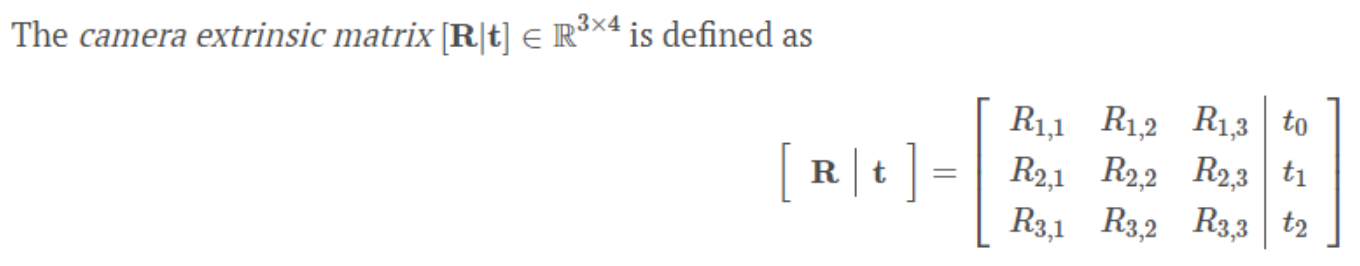

In [5]:
# 13.2
# basically load the image to get the dimensions, assuming they are all the same
im0 = cv2.imread("data/casper/sequence/frames0_0.png", cv2.IMREAD_GRAYSCALE)
im0 = im0.astype(float)/255
size = (im0.shape[1], im0.shape[0])
# only need to do this once
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],c['d1'], size, c['R'], c['t'], flags=0) 
R0, R1, P0, P1 = stereo[:4] 
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

In [6]:
im0_paths = glob.glob("data/casper/sequence/frames0_*.png")
im0_paths = natural_sort(im0_paths)
im1_paths = glob.glob("data/casper/sequence/frames1_*.png")
im1_paths = natural_sort(im1_paths)

In [7]:
ims0, ims1 = [], []
for image_cam0, image_cam1 in tqdm(zip(im0_paths, im1_paths), total=len(im0_paths)):
    im0 = cv2.imread(image_cam0, cv2.IMREAD_GRAYSCALE).astype(float)/255
    im0 = cv2.remap(im0, *maps0, cv2.INTER_LINEAR)
    ims0.append(im0)
    im1 = cv2.imread(image_cam1, cv2.IMREAD_GRAYSCALE).astype(float)/255
    im1 = cv2.remap(im1, *maps1, cv2.INTER_LINEAR)
    ims1.append(im1)

  0%|          | 0/26 [00:00<?, ?it/s]

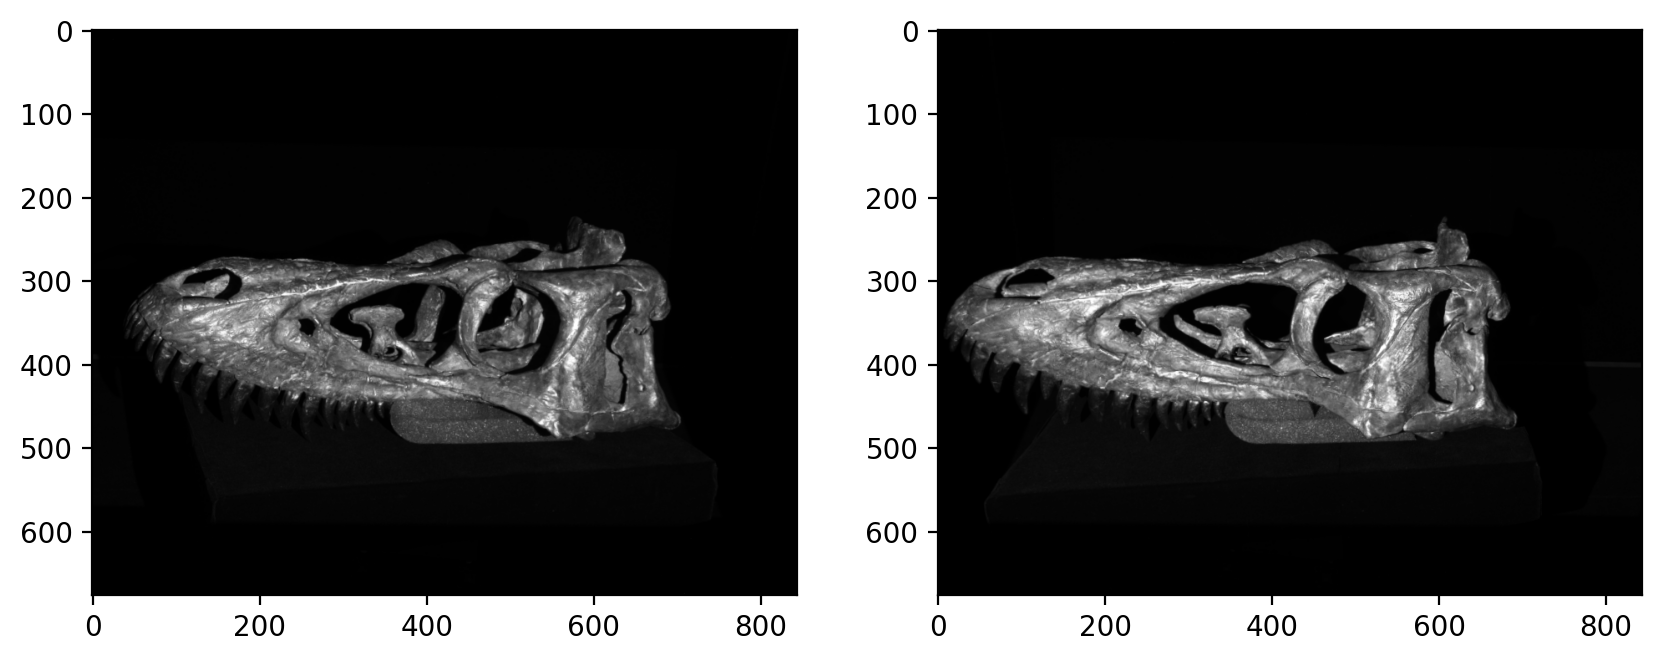

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(ims0[0], cmap='gray')
ax[1].imshow(ims1[0], cmap='gray');

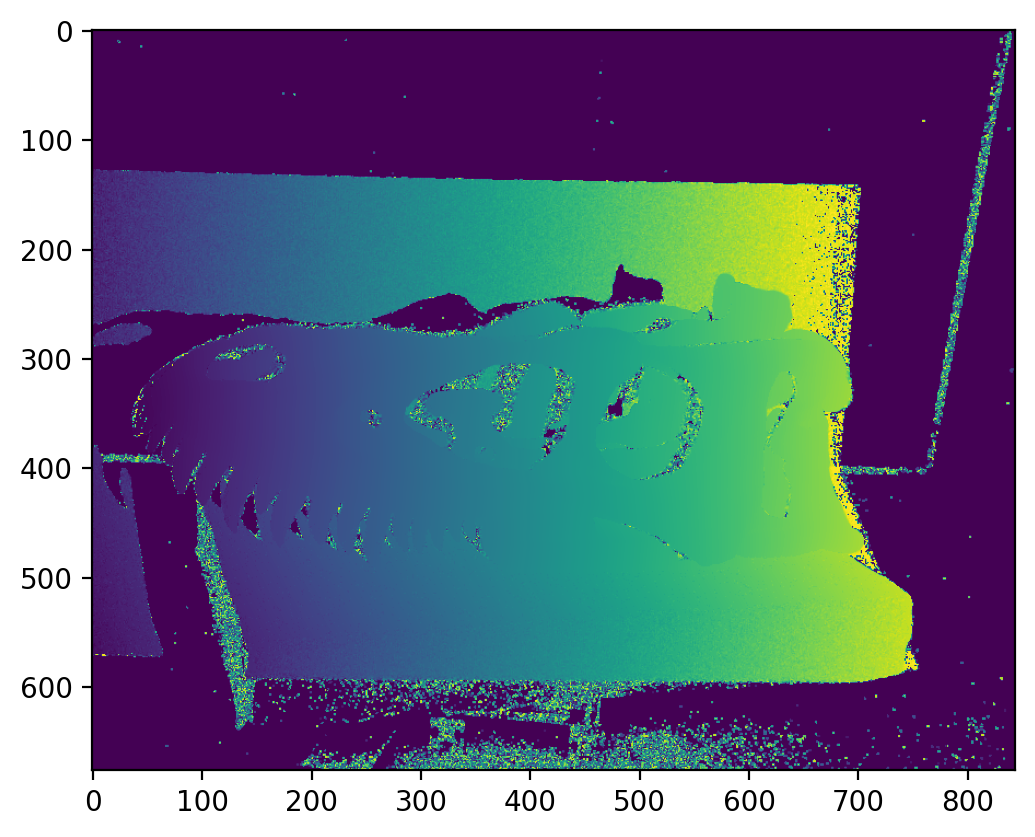

In [10]:
# 13.3
def unwrap(ims, n1):
    '''Unwrap the images into a single array'''
    primary_images = ims[2:18]
    fft_primary = np.fft.rfft(primary_images, axis=0)
    theta_primary = np.angle(fft_primary[1])

    secondary_images = ims[18:]
    fft_secondary = np.fft.rfft(secondary_images, axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    # heterodyne principle
    theta_c = (theta_secondary - theta_primary) % (2*np.pi)
    # order of primary phase
    o_primary = np.round((n1*theta_c - theta_primary) / (2*np.pi))
    # unwrapped phase
    theta = ((2*np.pi * o_primary + theta_primary) / n1) % (2*np.pi)
    return theta
theta0 = unwrap(ims0, 40)
theta1 = unwrap(ims1, 41)
plt.imshow(theta0);

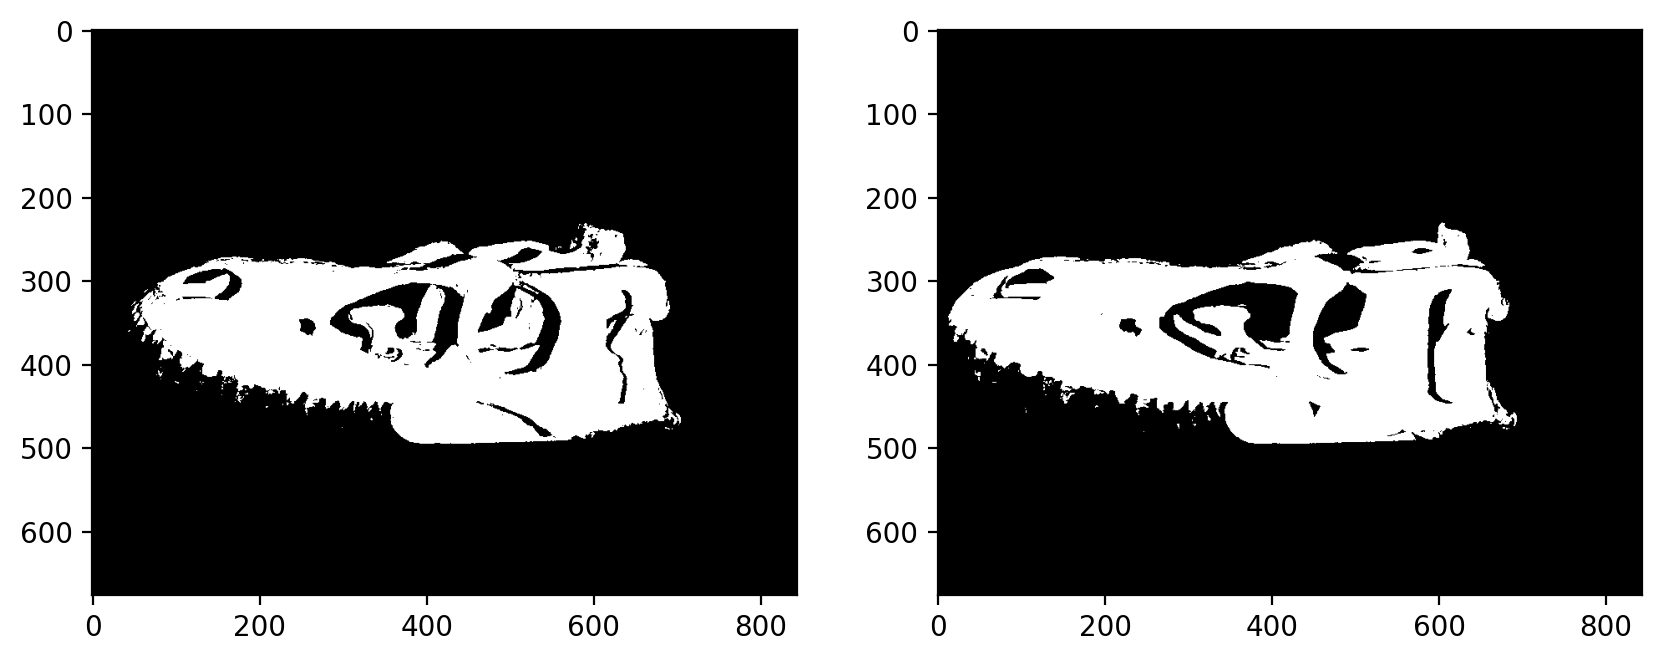

In [41]:
# 13.4 masks
# i set the threshold to 35/255 because it looked good
mask0 = (ims0[0] - ims0[1]) > 35/255
mask1 = (ims1[0] - ims1[1]) > 35/255
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(mask0, cmap='gray')
ax[1].imshow(mask1, cmap='gray');

  0%|          | 0/676 [00:00<?, ?it/s]

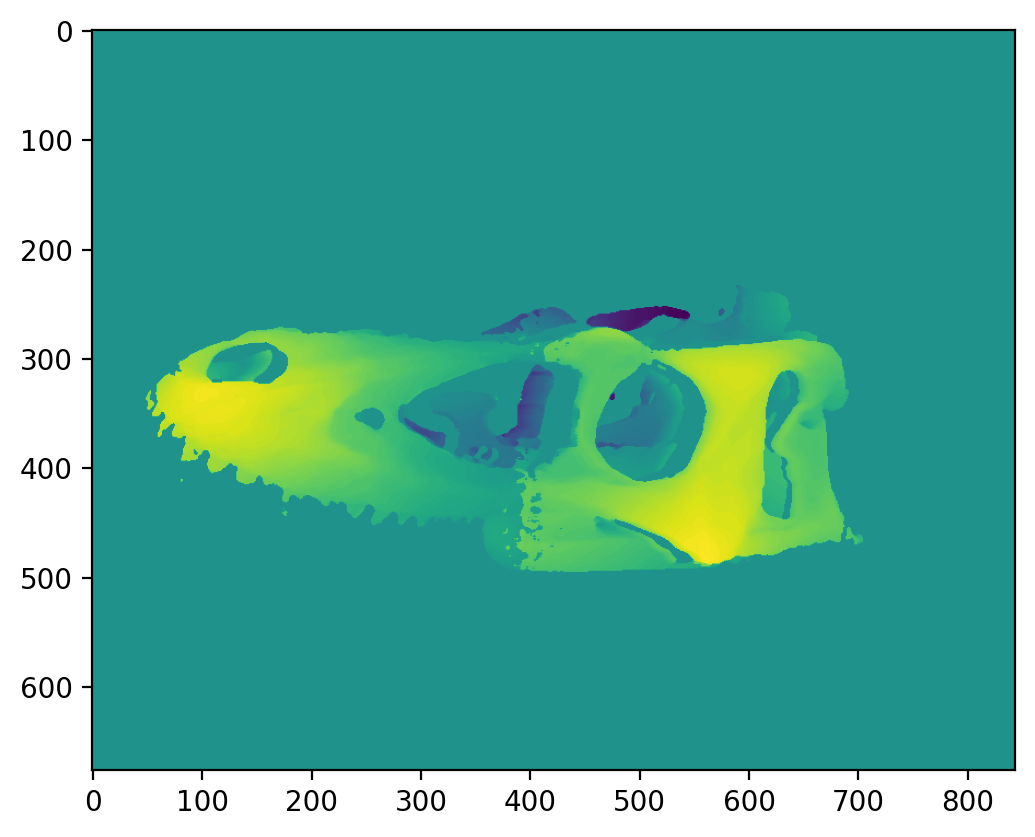

In [46]:
# 13.5
# pixel coordinates of matches between camera 0 and 1
q0s, q1s = [], []
disparity = np.zeros((im0.shape))

for i in tqdm(range(theta0.shape[0])):
    for j in range(theta0.shape[1]):
        if mask0[i,j]:
            epipolar_line = im1[i,:]
            # find j index that minimises distance between thetas
            j1 = np.argmin([abs(theta1[i,j1]-theta0[i,j]) if mask1[i,j1] else np.inf for j1 in range(len(epipolar_line))])
            
            q0s.append((j,i))
            q1s.append((j1,i))
            disparity[i, j] = j-j1          

# for k, (i0,j0) in enumerate(q0s):
#     i1, j1 = q1s[k]
    
disp = cv2.medianBlur(disparity.astype(np.float32), 5)
plt.imshow(disp);

In [47]:
q0s = np.array(q0s).T.astype(float)
q1s = np.array(q1s).T.astype(float)

In [57]:
# 13.6
Q = cv2.triangulatePoints(P0, P1, q0s, q1s)
Q = Pi(Q)
Q *= np.sign(Q[2])

pcd = o3d.geometry.PointCloud() 
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])